# Прогноз оттока клиентов в телекоме

Оператор связи хочет бороться с оттоком клиентов. Для этого сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Задача**: обучить на этих данных модель для прогноза оттока клиентов.

**Критерий успеха**: метрика ROC-AUC выше или равна 0.85.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
try:
    contract_df = pd.read_csv('datasets/contract_new.csv', parse_dates=['BeginDate'])
    internet_df = pd.read_csv('datasets/internet_new.csv')
    personal_df = pd.read_csv('datasets/personal_new.csv')
    phone_df = pd.read_csv('datasets/phone_new.csv')
except:
    contract_df = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate'])
    internet_df = pd.read_csv('/datasets/internet_new.csv')
    personal_df = pd.read_csv('/datasets/personal_new.csv')
    phone_df = pd.read_csv('/datasets/phone_new.csv')

In [3]:
def data_info(df):
    display(df.info())
    display(df.head())
    print(f'Полных дубликатов: {df.duplicated().sum()}')

In [4]:
def pie_plots(data, title, nrows=2, ncols=4):
    plt.figure(figsize=(12,7))    
    plt.suptitle(f'Распределение признаков {title}')

    for i, col in enumerate(data.drop(columns='customerID').columns.values):
        plt.subplot(nrows, ncols, i + 1)
        counts = data[col].value_counts()
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
        plt.title(col)
        
    plt.tight_layout()    
    plt.show()   
    
    
def plot_features(data):    
    num_data = data.select_dtypes(include=float)    
    count_num_features = len(num_data.columns)
    sns.set()
    
    fig, axes = plt.subplots(nrows=count_num_features, ncols=2, figsize=(12, 8))
    
    if count_num_features > 1:
        for i, column in enumerate(num_data.columns):
            sns.histplot(num_data[column], ax=axes[i, 0], bins=20) 
            axes[i, 0].set_title(f'Гистограмма {column}')
            
            sns.boxplot(num_data[column], ax=axes[i, 1])
            axes[i, 1].set_title(f'Ящик с усами {column}')
    elif count_num_features == 1:
        for column in num_data.columns:
            sns.histplot(num_data[column], ax=axes[0], bins=20) 
            axes[0].set_title(f'Гистограмма {column}')
            
            sns.boxplot(num_data[column], ax=axes[1])
            axes[1].set_title(f'Ящик с усами {column}')
            
    plt.tight_layout()
    plt.show()
    
    cat_data =  data.select_dtypes(include=[object, int])
    
    try:
        count_cat_features = len(cat_data.columns)
            
        fig, axes = plt.subplots(nrows=1, ncols=count_cat_features, figsize=(15, 12))

        if count_cat_features > 1:
            for i, column in enumerate(cat_data.columns):
                counts = cat_data[column].value_counts()
                axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
                axes[i].set_title(f'Распределение {column}')
        elif count_cat_features == 1:
            for column in cat_data.columns:
                counts = cat_data[column].value_counts()
                axes.pie(counts, labels=counts.index, autopct='%1.1f%%')
                axes.set_title(f'Распределение {column}')
                
        plt.tight_layout()
        plt.show()
    except:
        return

In [5]:
data_info(contract_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Полных дубликатов: 0


В датафрейме `contract` 7043 строки без пропусков. Столбец `TotalCharges` имеет некорректный тип данных object. Исследуем его на этапе предобработки. 

In [6]:
data_info(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Полных дубликатов: 0


В датафрейме `internet` 5517 строк без пропусков. Состоит из категориальных признаков.

In [7]:
data_info(personal_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Полных дубликатов: 0


В датафрейме `personal` 7043 строки без пропусков. Состоит из категориальных признаков.

In [8]:
data_info(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Полных дубликатов: 0


В датафрейме `personal` 6361 строка без пропусков. Кроме первичного ключа id пользователя, содержит один признак `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Данные состоят из нескольких файлов: информация о договоре, персональные данные клиента, информация об интернет-услугах, информация об услугах телефонии.

## Исследовательский анализ и предобработка данных

Изучим признак общих расходов абонента `TotalCharges` в `contract_df`.

In [9]:
incorrect_val = pd.to_numeric(contract_df['TotalCharges'], errors='coerce').isna()
contract_df.loc[incorrect_val]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Вывели те строки, которые содержат некорректное значение в `TotalCharges`. Наблюдаем пустые ячейки. Все они созданы одной датой `2020-02-01` – это значение равняется актуальности датафрейма, вероятно, пользователи еще не успели внести оплату. Предположим, что здесь пропуск обозначает выручку в размере 0.

In [10]:
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce').fillna(0)
contract_df['TotalCharges'].dtypes

dtype('float64')

In [11]:
contract_df['EndDate'].value_counts()

EndDate
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: count, Length: 67, dtype: int64

Признак `EndDate` является целевым, потому что содержит окончания действия договора. По значению `No` понятно, что клиент не прекратил пользоваться услугами. Создадим новый столбец с бинарным целевым признаком.

In [12]:
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')

/var/folders/gc/rvxphzg975x7t7lp37cxytcm0000gn/T/ipykernel_9925/3940540404.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')


In [13]:
contract_df['Terminate'] = (~contract_df['EndDate'].isna()).astype(int)

In [14]:
contract_df.describe()

,BeginDate,EndDate,MonthlyCharges,TotalCharges,Terminate
count,7043,1101,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,2018-03-12 18:21:15.204359680,64.761692,2115.312885,0.156325
min,2013-10-01 00:00:00,2014-06-01 00:00:00,18.250000,0.000000,0.000000
25%,2015-06-01 00:00:00,2017-05-01 00:00:00,35.500000,436.750000,0.000000
50%,2017-09-01 00:00:00,2018-06-01 00:00:00,70.350000,1343.350000,0.000000
75%,2019-04-01 00:00:00,2019-04-01 00:00:00,89.850000,3236.690000,0.000000
max,2020-02-01 00:00:00,2020-01-01 00:00:00,118.750000,9221.380000,1.000000
std,NaN,NaN,30.090047,2112.742814,0.363189


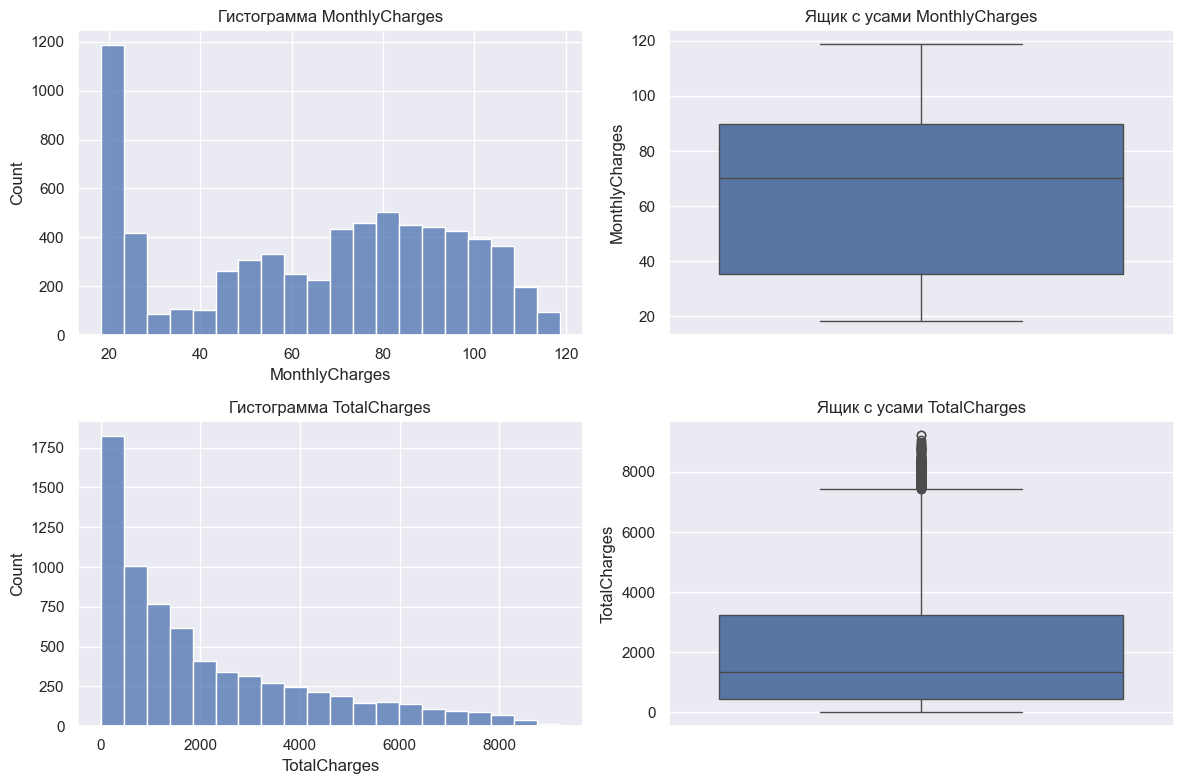

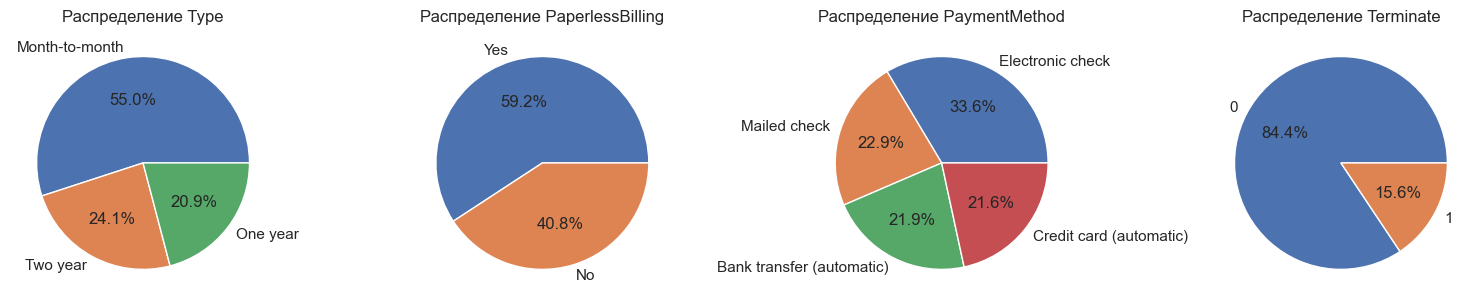

In [15]:
plot_features(contract_df.drop(columns=['customerID', 'EndDate']))

Нижний квантиль 25% пользователей по расходам за месяц `MonthlyCharges` составляет всего 35, а средний чек значение 64. Наблюдается пик пользователей с низкой долей расходов около 20. Также на гистограмме пик в районе нуля имеет `TotalCharges`, при этом средняя выручка по пользователю составляет 2115. Boxplot показывает наличие выбросов, а максимальный общий чек составляет 9221.

55% пользователей предпочитают пользоваться услугами с помесячной оплатой, но также есть 20.9% тех, кто заключает годовой договор и 24.1%, кто платит на два года вперед. Соотношение классов по типу платежа PaymentMethod сопоставимое без явного дисбаланса.

Расторгли договор только 15.6% пользователей от выборки.

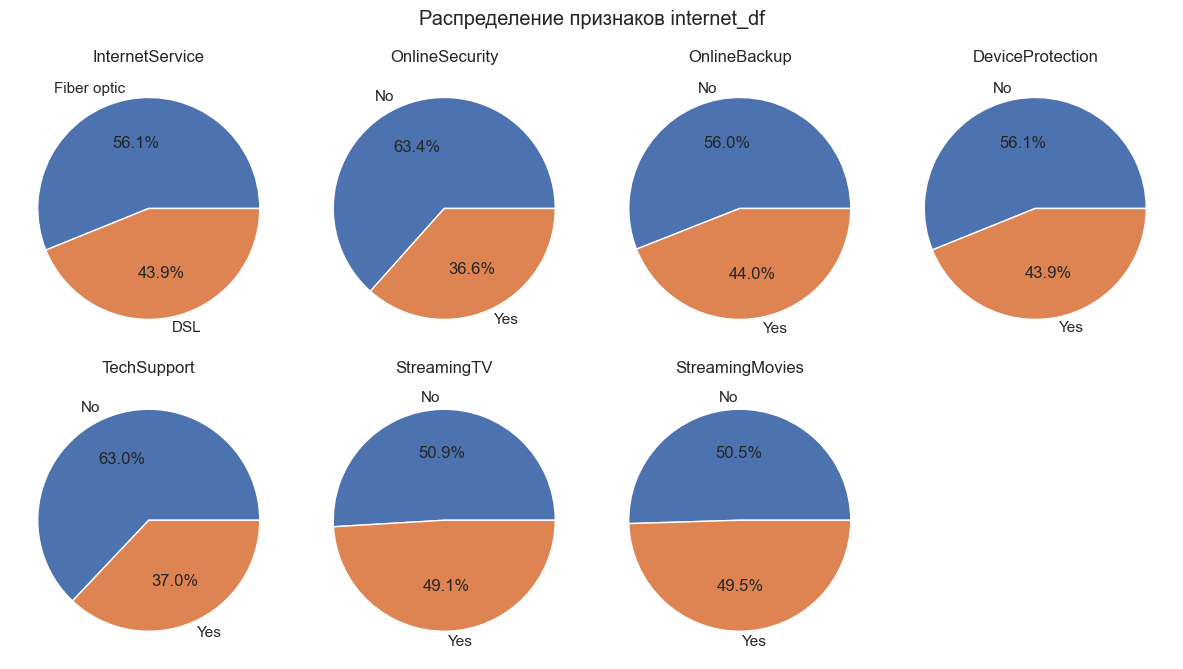

In [16]:
pie_plots(internet_df,'internet_df')

По распределению классов таблицы хранящей информацию об интернет-услугах отметим, 63.4% пользователей пользуются опцией блокировки опасных сайтов `OnlineSecurity`, а у 37% есть стриминговое телевидение `StreamingTV`. В остальном соотношение классов примерно одинаковое.

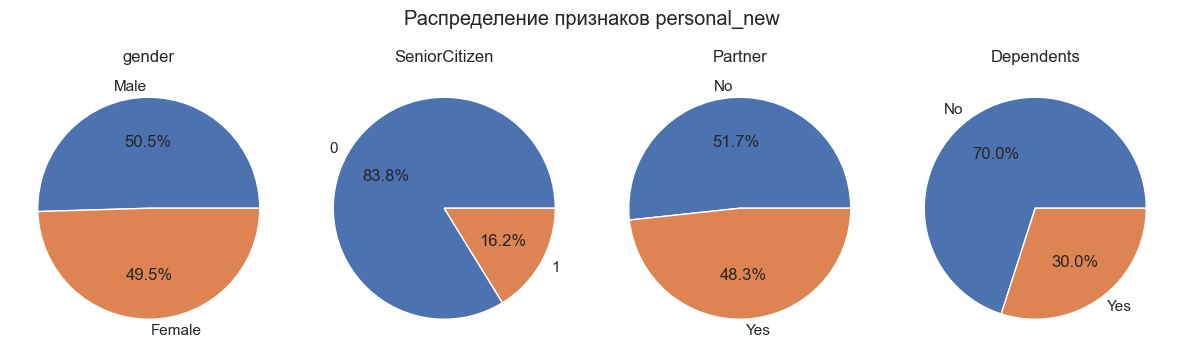

In [17]:
pie_plots(personal_df, 'personal_new')

Распределение классов таблицы с персональными данные клиента показывает, `SeniorCitizen`16.2% являются пенсионерами, `Dependents` у 30% есть дети. В остальном соотношение классов примерно одинаковое.

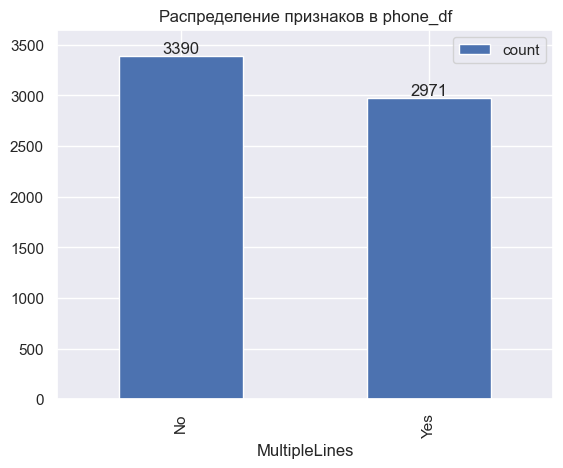

In [18]:
ax = phone_df['MultipleLines'].value_counts().plot(kind='bar', ylim=(0, 3650), title='Распределение признаков в phone_df', legend=True)
ax.bar_label(ax.containers[0])
plt.show()

В таблице phone_df один признак – подключение телефона к нескольким линиям одновременно, который равномерно распределен на оба класса.

## Объединение данных

Целевой признак `Terminate` о прекращении договора содержит датафрейм `contract_df`, объединим данные этой таблице.

In [19]:
full_data = contract_df.merge(internet_df, how='left')
full_data = full_data.merge(personal_df,  how='left')
full_data = full_data.merge(phone_df,  how='left')

In [20]:
full_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Terminate,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,0,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No


In [21]:
full_data.shape

(7043, 21)

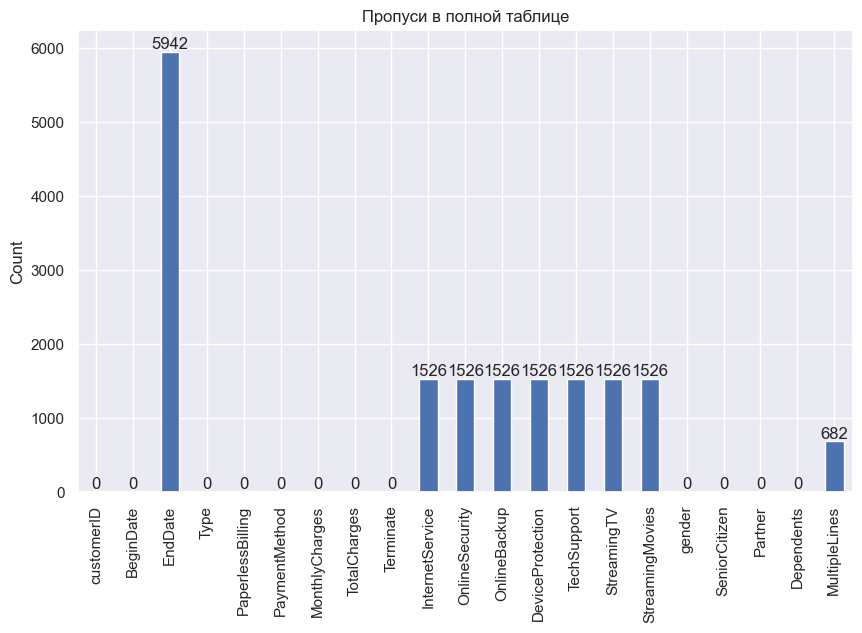

In [22]:
ax = full_data.isna().sum().plot(kind='bar', ylabel='Count', title='Пропуси в полной таблице', figsize=(10, 6))
ax.bar_label(ax.containers[0])
plt.show()

Так как размеры таблиц не равны между собой, то на выходе имеем пропущенные значения там, где нет данных для ключа `customerID`.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Сгенерируем новый признак – количество дней пользования договором. Знаем, что информация о договорах актуальна на 1 февраля 2020 года. Заполним пропуски в `EndDate` этой датой.

In [23]:
full_data['EndDate'] = full_data['EndDate'].fillna(pd.Timestamp('2020-02-01'))

In [24]:
full_data['DaysContract'] = (full_data['EndDate'] - full_data['BeginDate']).dt.days

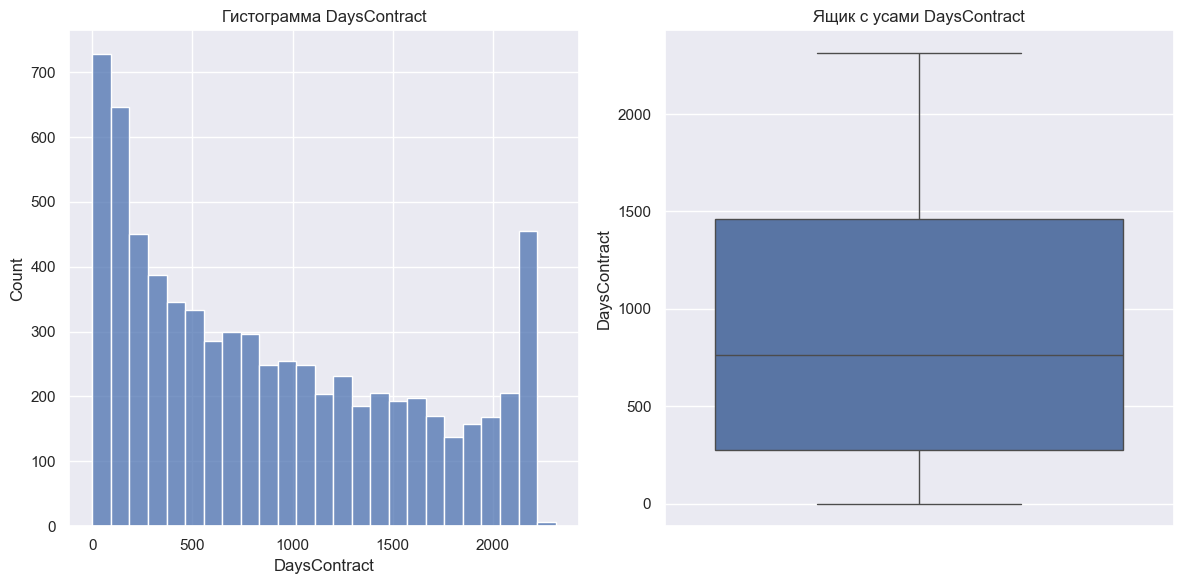

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

sns.histplot(full_data['DaysContract'], ax=axes[0], bins=25) 
axes[0].set_title(f'Гистограмма DaysContract')

sns.boxplot(full_data['DaysContract'], ax=axes[1])
axes[1].set_title(f'Ящик с усами DaysContract')
    
plt.tight_layout()
plt.show()

Наблюдаем два пика – вначале и конце гистограммы. Последняя вершина объяснима – это пользователи, которые не расторгали договор и их количество дней выше. В среднем длительность договора составляет 898 дней.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Terminate', 'SeniorCitizen', 'DaysContract']


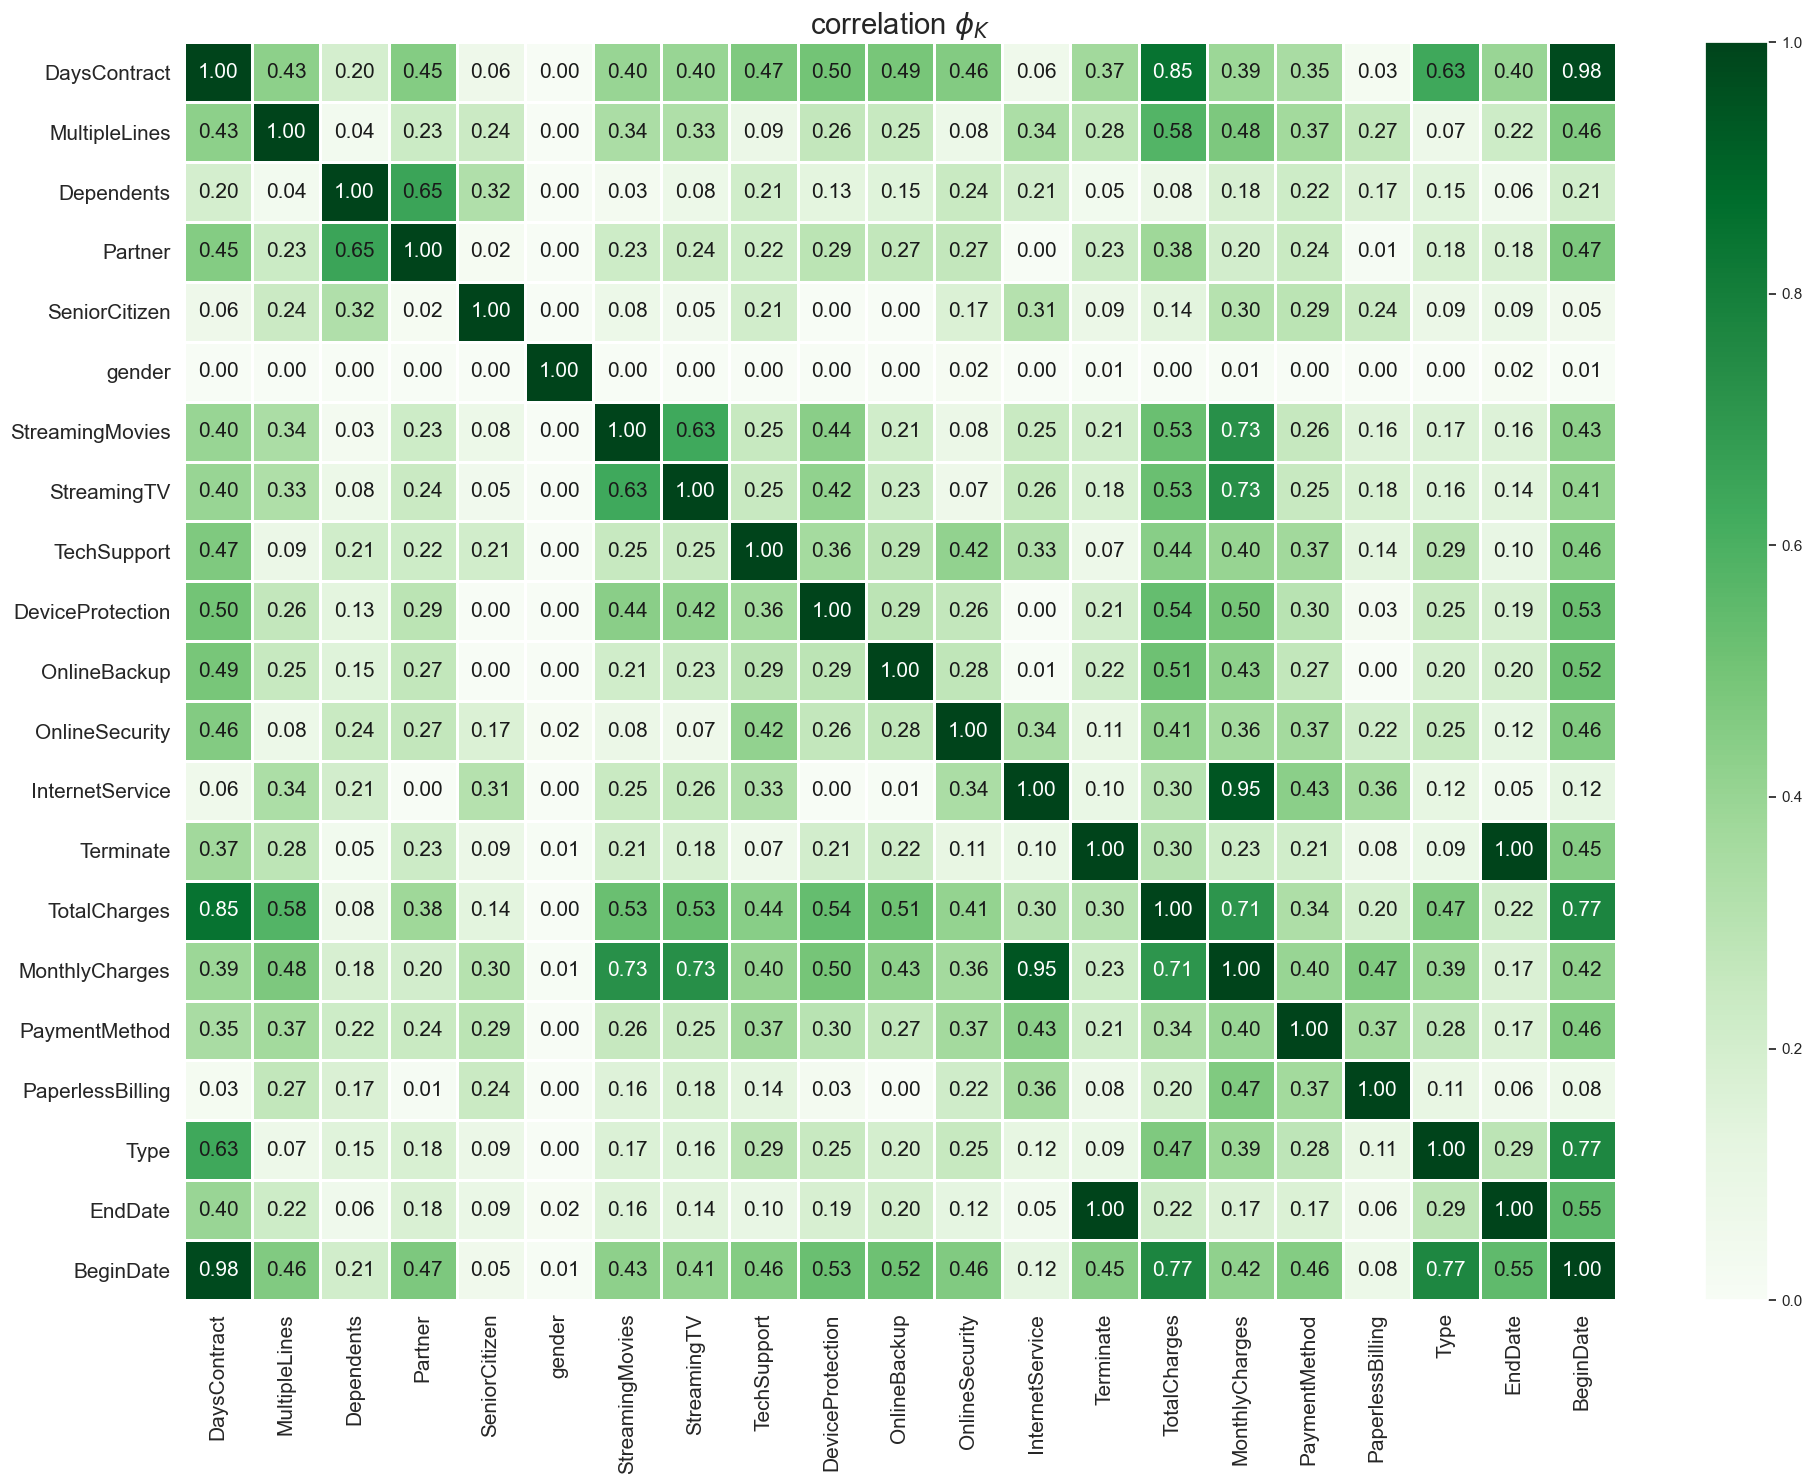

In [26]:
phik_overview = phik_matrix(full_data.drop(columns='customerID'))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Наблюдается полная корреляция у признака `EndDate` с целевым `Terminate`, что объясняется утечкой. Топ 3 признака по корреляции: BeginDate 0.45, DaysContract 0.37, TotalCharges 0.30. Даты начала и окончания договора исключим из модели, они не должны влиять на прекращение договора. Пол пользователя не коррелирует ни с какими данными. 

`InternetService` и `MonthlyCharges` имеют высокую корреляцию в 0.95. При использовании моделей регрессии лучше использовать только признак `MonthlyCharges`, чтобы избежать мультиколлинеарности.

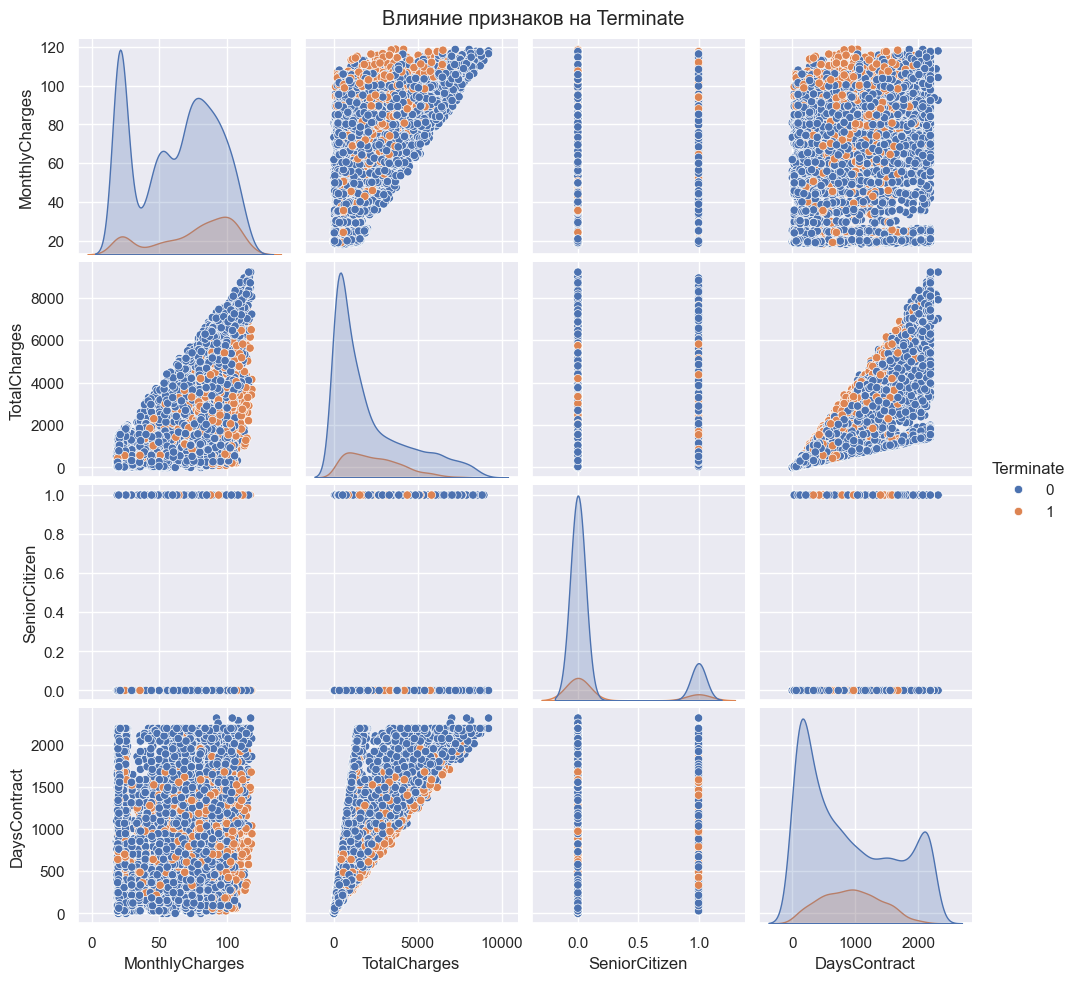

In [27]:
sns.pairplot(full_data, hue='Terminate')
plt.suptitle(f'Влияние признаков на Terminate')
plt.subplots_adjust(top=0.95)
plt.show()

Наблюдается скопление точек на графика пересечения `MonthlyCharges` и `TotalCharges`. При высокой месячной стоимости увеличенная плотность расторжения договора.

Проверим это нагляднее.

Соотношение `Terminate` по срезу `MonthlyCharges` > 100:

In [28]:
full_data[full_data['MonthlyCharges'] > 100]['Terminate'].value_counts() / len(full_data[full_data['MonthlyCharges'] > 100]['Terminate'])

Terminate
0    0.711752
1    0.288248
Name: count, dtype: float64

Соотношение `Terminate` по всей выборке:

In [29]:
full_data['Terminate'].value_counts() / len(full_data['Terminate'])

Terminate
0    0.843675
1    0.156325
Name: count, dtype: float64

Действительно, пользователи с расходами за месяц выше 100 на 13% чаще прекращают договор по отношению к среднему значению всей выборки.

## Построение пайплайна

Применим OneHotEncoding к категориальным признакам, они почти все бинарные, что упрощает кодирование.

In [30]:
RANDOM_STATE = 60524
TEST_SIZE = 0.25

In [31]:
X = full_data.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Terminate'])
y = full_data['Terminate']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=RANDOM_STATE,
                                                    test_size=TEST_SIZE,
                                                    stratify=y)

In [32]:
ohe_columns = ['PaperlessBilling', 'PaymentMethod', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies',
               'gender', 'Partner', 'Dependents', 'MultipleLines']

ord_column = ['Type']

num_columns = ['MonthlyCharges', 'TotalCharges', 'DaysContract']

Пропуски содержаться в категориальных колонках, заполним их заглушкой `unknown`. Использовать стратегию заполнения пропусков модой не рекомендуется. Соотношение классов равное.

In [33]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

In [34]:
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
    ('ord', OrdinalEncoder(categories=[['Month-to-month', 'One year', 'Two year']], 
                           handle_unknown='use_encoded_value',
                           unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1))
])

In [35]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_column),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [36]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Пайплайн готов.

## Обучение моделей машинного обучения

In [37]:
param_distributions  = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'models__C': [1, 10, 100, 1000],
        'models__solver': ['sag', 'saga', 'liblinear']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_leaf': range(2, 50, 10),
        'preprocessor__num': ['passthrough']
    },
    {
        'models': [CatBoostClassifier(iterations=500, random_state=RANDOM_STATE, verbose=False)],
        'models__learning_rate':[0.03, 0.1, 0.3, 1],
        'models__l2_leaf_reg': range(1, 11),
        'models__max_depth': range(2, 11),
        'preprocessor__num': ['passthrough']
    }
]

In [38]:
rscv =  RandomizedSearchCV(pipe_final,
                           param_distributions=param_distributions,
                           cv=3,
                           scoring='roc_auc',
                           n_iter=150,
                           random_state=RANDOM_STATE,
                           n_jobs=-1)

In [39]:
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'Internet...
                                         'models__max_depth': range(2, 11),
                                         'models__min_samples_leaf': range(2, 50, 10),
                                         'preprocessor__num': ['passthrough']},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x145eae270>],
                                         'models__l2_leaf_reg': range(1, 11),
                                         'models__learning_rate': [0.03, 0.1,
                                                                   0.3, 1],
                                         'models__max_depth': range(2, 11),
                                         'preprocessor__num': ['passthrough']}],
                   random_state=60524, scoring='roc_auc')

In [40]:
cv_res = pd.DataFrame(rscv.cv_results_)
cv_res[['rank_test_score', 'param_models', 'mean_test_score', 'params']].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
85,1,<catboost.core.CatBoostClassifier object at 0x...,0.918123,"{'preprocessor__num': 'passthrough', 'models__..."
35,2,<catboost.core.CatBoostClassifier object at 0x...,0.914695,"{'preprocessor__num': 'passthrough', 'models__..."
133,3,<catboost.core.CatBoostClassifier object at 0x...,0.912441,"{'preprocessor__num': 'passthrough', 'models__..."
54,4,<catboost.core.CatBoostClassifier object at 0x...,0.907524,"{'preprocessor__num': 'passthrough', 'models__..."
49,5,<catboost.core.CatBoostClassifier object at 0x...,0.906188,"{'preprocessor__num': 'passthrough', 'models__..."


In [41]:
print('Метрика roc_auc для лучшей модели:\n', rscv.best_score_)
print('\nЛучшая модель и её параметры:\n', rscv.best_params_)

Метрика roc_auc для лучшей модели:
 0.9181226397866354

Лучшая модель и её параметры:
 {'preprocessor__num': 'passthrough', 'models__max_depth': 2, 'models__learning_rate': 0.3, 'models__l2_leaf_reg': 1, 'models': <catboost.core.CatBoostClassifier object at 0x145eae270>}


Отлично, модель CatBoostClassifier дала высокий результат по метрике ROC-AUC, который превосходит критерий успеха выше 0.85. Изучим лучшую модель.

## Анализ модели

Визуализируем вклад признаков в каждое предсказание модели с помощью SHAP.

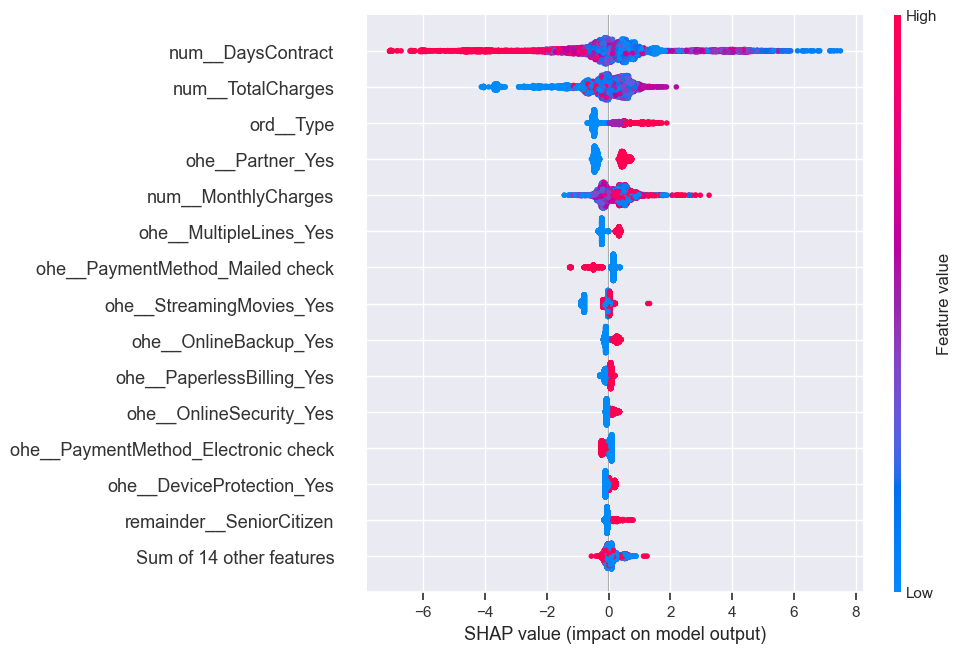

In [42]:
best_model = rscv.best_estimator_

X_train_transformed = pd.DataFrame(best_model.named_steps['preprocessor'].transform(X_train), 
                                   columns=best_model.named_steps['preprocessor'].get_feature_names_out())

explainer = shap.TreeExplainer(best_model.named_steps['models'])
shap_values = explainer(X_train_transformed)

shap.plots.beeswarm(shap_values, max_display=15) 

Прочитаем график. Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0 (не прекратил договор), а положительные справа — к классу 1 (прекратил договор). Цвет точки отражает значения каждого признака объекта.

С точки зрения модели, наиболее важными признаком для прогноза является признак `DaysContract`, высокое значение дней тянет класс к 0, низкое к 1. Низкое значение `TotalCharges` и `MonthlyCharges` склоняет прогноз в сторону продления договора. `Type` с оплатой на 1 или 2 года тянет класс к прекращению. Интересно отметить, что наличие супруга или супруги, согласно модели, как-то связанно с повышенным риском прекращением договора.

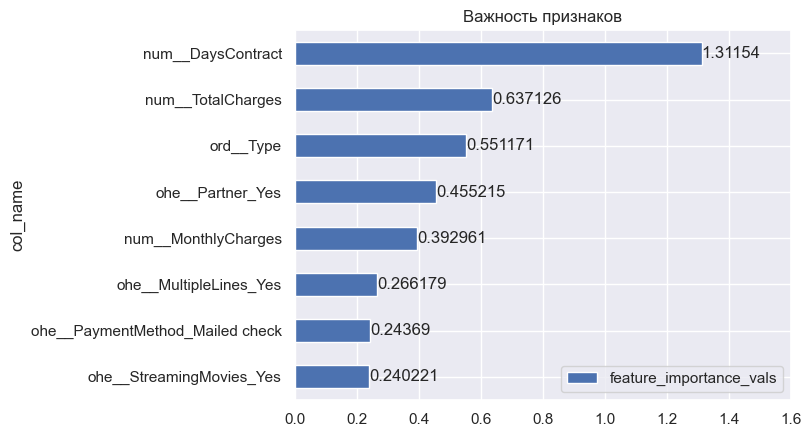

In [43]:
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train_transformed.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values('feature_importance_vals', ascending=False, inplace=True)

ax = feature_importance.head(8).sort_values('feature_importance_vals').plot(kind='barh', x='col_name', xlim=(0, 1.6), y='feature_importance_vals')
ax.bar_label(ax.containers[0])
plt.title('Важность признаков')
plt.show()

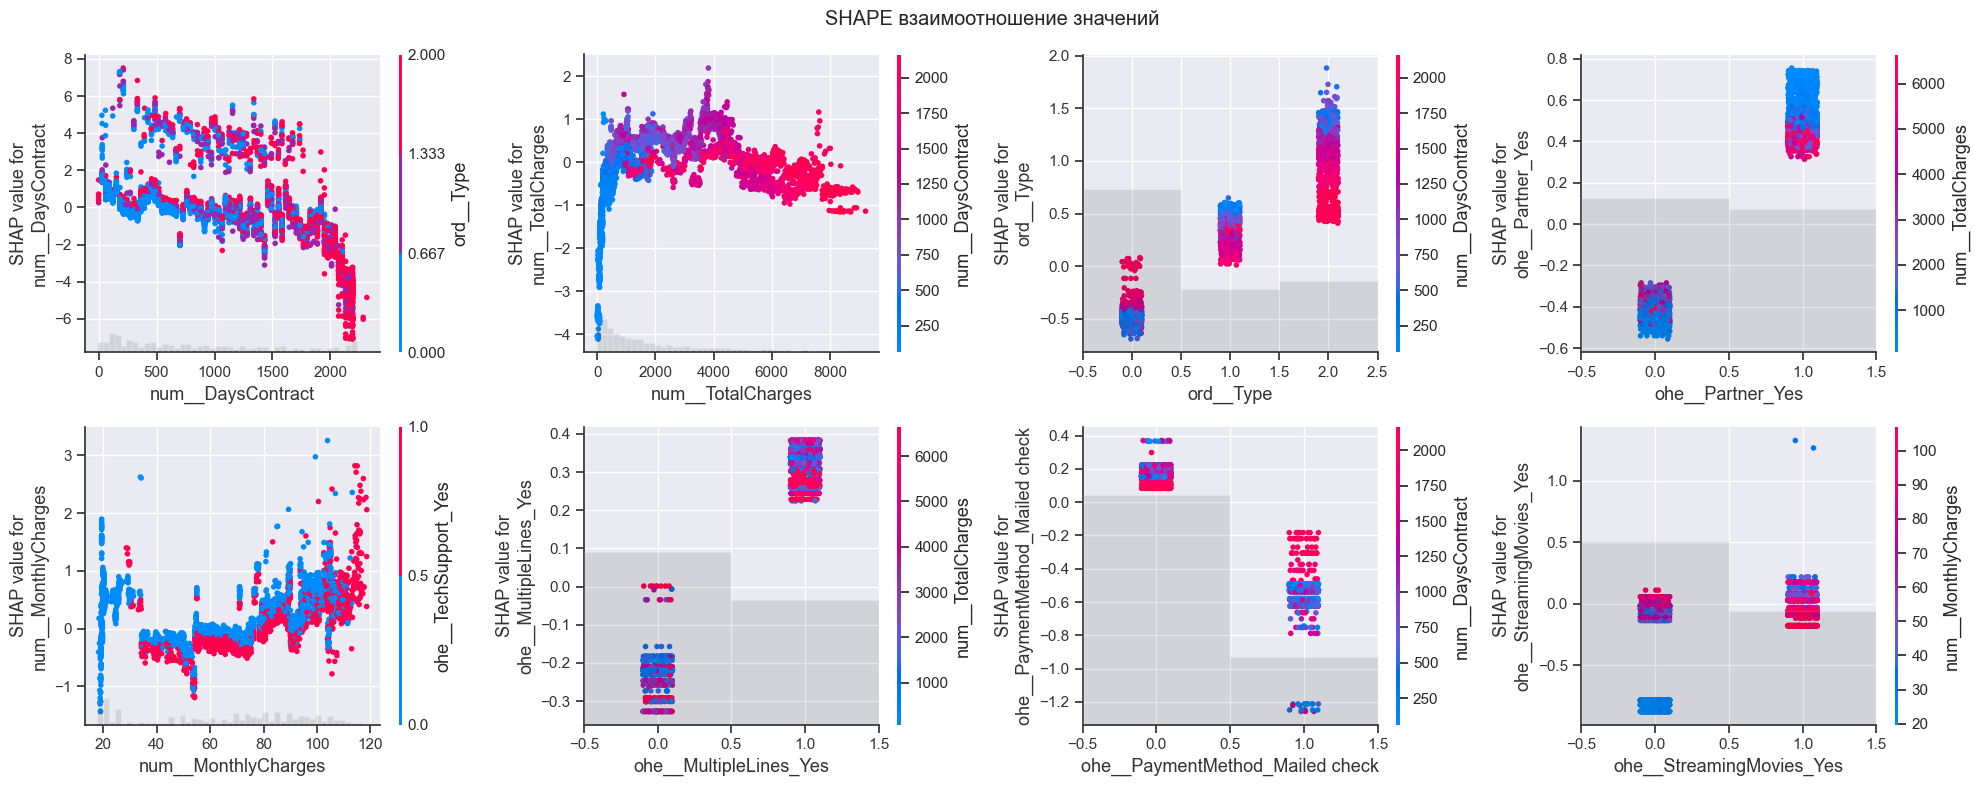

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
axes = axes.ravel()
plt.suptitle(f'SHAPE взаимоотношение значений')

for i, col in enumerate(feature_importance['col_name'][:8]):
    shap.plots.scatter(shap_values[:,col], ax=axes[i], show=False, color=shap_values)
    
plt.tight_layout()    
plt.show()  

После 1500 дней в `DaysContract` наблюдается резкое влияние на сохранение договора. В `TotalCharges` виден симметричный рост общей выручки с ростом дней договора, что логично. Однако, диапазон значений от 1000 до 4000 влияет на увеличение вероятности расторжения договора. В `Type` маленькие и большие значения `DaysContract` встречаются во всех трех типах срока договора: помесячном, годовом и двух годовом. Как заметили ранее, помесячная оплата коррелирует со снижением риска расторжения. Наличие технической поддержки по значением `MonthlyCharges` в большинстве случаев коррелирует со снижением вероятности расторжения. Подключение телефона к нескольким линиям одновременно в признаке `MultipleLines` модель определила, как увеличивающую влияние на расторжение договора. 

**Запустим модель на тесте.**

In [45]:
y_pred_proba = best_model.predict_proba(X_test)[:,1]

In [46]:
roc_auc_score(y_test, y_pred_proba)

0.9331567355928057

Превосходно. Модель на тесте дала метрику ROC-AUC 0.9331, по сравнению с 0.9181 на кросс-валидации.

Выберем порог классификации.

In [47]:
for threshold in np.arange(0.1, 1, 0.1):
    y_pred = (y_pred_proba >= threshold)
    print(f'f1_score {round(threshold, 2)}:', f1_score(y_test, y_pred))

f1_score 0.1: 0.596319018404908
f1_score 0.2: 0.7083333333333334
f1_score 0.3: 0.7677902621722846
f1_score 0.4: 0.7984031936127745
f1_score 0.5: 0.7882599580712788
f1_score 0.6: 0.7665198237885462
f1_score 0.7: 0.7494356659142212
f1_score 0.8: 0.7089201877934272
f1_score 0.9: 0.5602094240837696


С порогом 0.4 получаем наивысшее значение f1 0.7984.

In [48]:
y_pred = (y_pred_proba >= 0.35).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1486
           1       0.84      0.74      0.79       275

    accuracy                           0.94      1761
   macro avg       0.90      0.86      0.88      1761
weighted avg       0.94      0.94      0.94      1761



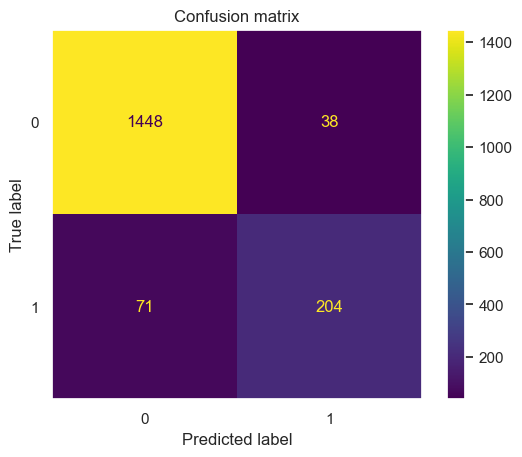

In [49]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=best_model.classes_)
plt.title('Confusion matrix')
plt.grid(False)
plt.show()

Данная модель максимально ориентированна на достижение высокой метрики ROC-AUC из полученного задания.

В зависимости от бизнес-метрик, на этапе обслуживания модели, рекомендуется корректировать веса классов и целевую метрику таким образом, чтобы увеличить точность и полноту предсказанного класса. Необходимо оценить, что страшнее по прибыли: не выдать промокод клиенту, который собирается уходить или выдать промокод тому, кто готов был бы платить по стандартному прайсу.

## Общий вывод и рекомендации заказчику

В данном проекте была выполнена задача построения модели машинного обучения по прогнозу оттока клиентов. 

Получены 4 таблицы с данными:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Целевой признак расторгнет ли пользователь договор `Terminate`, сгенерирован на основе данных признака `EndDate` с датой прекращения договора, где пропуски означают продолжение пользования услугами. Сгенерирован новый признак `DaysContract` на основании разницы дат заключения и расторжения договора, который отображает колличество дней пользования услугами.

Данные предобработаны от пропусков. Наличие даты окончания договора является утечкой целевого признака, поэтому признак был удален. 

Исследовательский анализ данных выявил, что расторгнувших договоров от общей выборки составляет 15.6% пользователей. В среднем выручка за срок жизни клиента равняется 2115. Обнаружена слабая корреляция `DaysContract` с таргетом на 0.37 и `TotalCharges` на 0.30. Среди клиентов с чеком `MonthlyCharges` выше 100 – 28% расторгли договор, что на 13% выше значения по всей выборке. К дополнительным наблюдениям выходящим за рамки данного проекта, можно отнести корреляцию наличия супруга или супруги с наличием детей со значением 0.65.

После слияния таблиц, пропуски обработаны в пайплайне заглушкой `unknown`. Все они находились в категориальных признаках.

В процессе поиска лучшей модели протестированы: KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier и CatBoostClassifier с различным перебором гиперпараметров. Лучшей показала себя модель CatBoostClassifier со следующими гиперпараметрами:

In [50]:
params_model = best_model.named_steps['models'].get_params()
params_model = pd.DataFrame(data=params_model.values(), index=params_model.keys(), columns=['best_params'])
params_model

,best_params
iterations,500
verbose,False
random_state,60524
max_depth,2
learning_rate,0.3
l2_leaf_reg,1


Метрика ROC-AUC на кросс-валидации составляет 0.9181.

Все признаки, которые были использованы для обучения лучшей модели:

In [51]:
print(X_train.columns.values)

['Type' 'PaperlessBilling' 'PaymentMethod' 'MonthlyCharges' 'TotalCharges'
 'InternetService' 'OnlineSecurity' 'OnlineBackup' 'DeviceProtection'
 'TechSupport' 'StreamingTV' 'StreamingMovies' 'gender' 'SeniorCitizen'
 'Partner' 'Dependents' 'MultipleLines' 'DaysContract']


Топ 5 по важности признаков:
- DaysContract;
- TotalCharges;
- Type;
- Partner;
- MonthlyCharges.

Высокое значение `MonthlyCharges` и `Type` со значением срока заключения договора на 1 или 2 года, тянут предсказание класса к расторжению договора. А чем выше `DaysContract` и ниже `TotalCharges`, тем выше вероятность продолжать пользоваться услугами и далее. Для тарифов со значением `MonthlyCharges` от 20 до 40, техническая поддержка благоприятно влияет на вероятность продления договора.

На тесте метрика ROC-AUC составляет 0.9331. Данные значения превосходят заданный критерий успеха не менее 0.85.

В дальнейшем рекомендуется корректировать веса классов для минимизации False positive или False negative ошибок. Если отправка промокода уже лояльному клиенту, относительно не затратное для бизнеса действие с точки зрения недополученной прибыли, тогда веса классов модели изменить в пользу метрики recall для более эффективного нахождения оттока. В обратном случае сфокусироваться на качестве метрики precision.